# Kmeans cluster investigation
- looks at the expression levels of known markers (given cell-type) of specific clusters.(part 1)
- looks for number of mye&lymph conflicts in specified cluster. (part 1)
- compares expression levels across all genes between two specified clusters. (part 2)

In [3]:
# ------- SERVER EXTENSIONS ---------
lib =  r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities/droplet_dataset'
lib2 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities'
lib3 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/data_analysis'
lib4 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy'
lib5 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/scripts'
lib6 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/scripts/preprocess_data'
import sys
sys.path.append(lib)
sys.path.append(lib2)
sys.path.append(lib3)
sys.path.append(lib4)
sys.path.append(lib5)
sys.path.append(lib6)
from classifying_cell_types import *
from utilities.general_helpers import *
# ------- SERVER EXTENSIONS ---------
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.manifold import TSNE
import pickle
# from Bio.Cluster import kcluster
# from Bio.Cluster import kcluster
# import pyclustering

import os
import numpy as np
import yaml
from os.path import join
import os
import pandas
from collections import Counter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sys
import seaborn as sns
# import statsmodels as sm
import scipy.stats as stats
from scipy.stats import rankdata
from sklearn.manifold import TSNE
import pickle
import numpy as np
from utilities.general_helpers import flatten_list
# from utilities.ML_environment import find_marker_genes_in_cluster
from shutil import copyfile
import matplotlib.pyplot as plt

###### (MUST) Data path (uploading):

In [6]:
print("Important Note: you are uploading cohort file and kmeans file. Make sure they are compatible")
KMEANS_PATH = fr'/storage/md_keren/shitay/outputs/clustering/kmeans/row_kmeans'

filtered_cells_path = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_10.6.21.pkl'
cohort = pickle.load(open(filtered_cells_path, 'rb'))
filtered_cells = cohort[filtered_cells.cells_information.getattr('is_immune')]

# empty_barcodes_path = r'/storage/md_keren/shitay/outputs/CellBender/empty_droplets_barcodes.csv'
# empty_barcodes_df = pd.read_csv(empty_barcodes_path)

Important Note: you are uploading cohort file and kmeans file. Make sure they are compatible


Extracts wanted cluster:

In [4]:
# Extract kmeans solution (K) and cluster (cls_idx) 
K = 11
cls_idx = 7
path = join(KMEANS_PATH, f'kmeans_immune_cells_var0.315_k_{K}.pkl')
kmeans = pickle.load(open(path, 'rb'))
print(f'K = {K}')
print(f'cluster idx: {cls_idx}')

cluster_cells = filtered_cells[kmeans['clusters'][cls_idx-1]]

K = 11
cluster idx: 7


Prints how many cell having a mye & lymph conflict:

In [5]:
mye = np.array([cluster_cells.cells_information.getattr('is_myeloid')])
lym = np.array([cluster_cells.cells_information.getattr('is_lymphoid')])
# np.concatenate((mye, lym), axis=0)
print(f'number of cell in cluster: {cluster_cells.number_of_cells}')
print(f'number of mye&lymph-conflict cells: {np.sum(mye & lym )}')

number of cell in cluster: 7587
number of mye&lymph-conflict cells: 38


Prints cell-types in the given cluster that have been found during marker classification process:

In [6]:
print(f'Cell-types shown in cluster {cls_idx}, K={K}:')
sorted(Counter(flatten_list(cluster_cells.cells_information.getattr('cell_type_list'))).items(), key=lambda x: x[1], reverse=True)

Cell-types shown in cluster 7, K=11:


[('Immune_general', 3727),
 ('Neutrophils', 3411),
 ('Granolocytes', 1952),
 ('B cells', 290),
 ('T cells', 237),
 ('CD8 Cytotoxic T cells', 82),
 ('Exhausted T cells', 66),
 ('myeloid cells_general_mature', 57),
 ('cDCs_dendritic_cells', 56),
 ('CD4 helper T cells', 41),
 ('NKT cells', 29),
 ('myeloid cells_general_immature', 17),
 ('pDCs', 15),
 ('Activated T cells', 14),
 ('Memory CD8 T cells', 11),
 ('Monocyte_mature', 9),
 ('Macrophage_mature', 7),
 ('Regulatory T cells', 7),
 ('Memory CD4 T cells', 6),
 ('NK cells', 4),
 ('Regulatory CD4 T cells', 3),
 ('Memory T cells', 2),
 ('Monocyte_immature', 1)]

Takes neutrophils markers and show expression levels of cells in cluster:

In [8]:
print('take neutrophils markers and show expression levels of cells in cluster')
neutrophils_markers = 'FUT4;FCGR3B;CXCR1;CXCR2;G0S2;CSF3R;FCGR3A'
neutrophils_markers = neutrophils_markers.split(';')
gene_idx = [cluster_cells.gene_names.index(marker) for marker in neutrophils_markers if marker in cluster_cells.gene_names]
neu_cells = cluster_cells[['Neutrophils' in vv for vv in cluster_cells.cells_information.getattr('cell_type_list')]]

ll= list(zip(neu_cells.samples,neu_cells.barcodes))#
values = [list(map(list, zip(neu_cells.samples,neu_cells.barcodes)))[i] + neu_cells.counts[:, gene_idx].round(2).tolist()[i] for i in range(len(ll))]
columns = ['Sample', 'Barcode']+[neu_cells.gene_names[idx] for idx in gene_idx]
df = pd.DataFrame(values, columns=columns).sort_values(['Sample', 'Barcode'])
df.head(2)

take neutrophils markers and show expression levels of cells in cluster


,Sample,Barcode,FUT4,FCGR3B,CXCR1,CXCR2,G0S2,CSF3R,FCGR3A
0,M100,TCTATTGGTAAGTGTA-1,0.92,0.0,0.0,0.0,0.0,0.0,0.0
1,M101,AAACCTGAGCGTAATA-1,1.19,0.0,0.0,0.0,0.0,0.0,0.0


Remove comment if you want to remove the DF:

In [9]:
# df.to_csv(r'/storage/md_keren/shitay/garbage/cluster9_k11.csv', index=False)

Shows the number of neutrophil markers, the identified neutrophil cells express:

In [10]:
print('Number of neutrophil markers, the identified neutrophil cells express (cluster #9 in k=11):')
dic = sorted(dict(Counter(np.sum(neu_cells.counts[:, gene_idx]!=0, axis=1))).items())
{f'n_cells express {x} markers': y for x,y in dic}

Number of neutrophil markers, the identified neutrophil cells express (cluster #9 in k=11):


{'n_cells express 1 markers': 3257,
 'n_cells express 2 markers': 144,
 'n_cells express 3 markers': 6,
 'n_cells express 5 markers': 3,
 'n_cells express 6 markers': 1}

Shoes neutrophil markers expression distribution:

Neutrophil markers expression distribution:


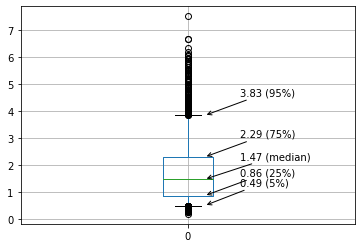

In [11]:
print('Neutrophil markers expression distribution:')
arr = neu_cells.counts[:, gene_idx].flatten()
arr = arr[arr!=0]
annotate_boxplot(pd.DataFrame(arr).boxplot(whis=[5, 95], return_type='dict'), arr)

###### 2. Conducts a comparison across all genes of 2 specified clusters: 

In [4]:
# Extract kmeans solution (K) and cluster (cls_idx) 
K_solution_1 = 11
cluster_idx_1 = 7

K_solution_2 = 11
cluster_idx_2 = 9

print(f'Conducting a comparison:')
path = join(KMEANS_PATH, f'kmeans_immune_cells_var0.315_k_{K_solution_1}.pkl')
kmeans = pickle.load(open(path, 'rb'))
cluster_1_cells = filtered_cells[kmeans['clusters'][cluster_idx_1-1]]
print('First cluster:')
print(f'K = {K_solution_1}')
print(f'cluster_idx: {cluster_idx_1}')
print(f'Number of cells: {cluster_1_cells.number_of_cells}')


path = join(KMEANS_PATH, f'kmeans_immune_cells_var0.315_k_{K_solution_2}.pkl')
kmeans = pickle.load(open(path, 'rb'))
cluster_2_cells = filtered_cells[kmeans['clusters'][cluster_idx_2-1]]
print('\nSecond cluster:')
print(f'K = {K_solution_2}')
print(f'cluster_idx: {cluster_idx_2}')
print(f'Number of cells: {cluster_2_cells.number_of_cells}')

Conducting a comparison:
First cluster:
K = 11
cluster_idx: 7
Number of cells: 7587

Second cluster:
K = 11
cluster_idx: 9
Number of cells: 2883


In [5]:
# get subset of the cluster

print(f'Number of cells in cluster {cluster_1_cells.number_of_cells}')
neutrophils_markers = 'FUT4;FCGR3B;CXCR1;CXCR2;G0S2;CSF3R;FCGR3A'
neutrophils_markers = neutrophils_markers.split(';')
gene_idx = [cluster_1_cells.gene_names.index(marker) for marker in neutrophils_markers if marker in cluster_1_cells.gene_names]
sub_cluster_1_cells = cluster_1_cells[['Neutrophils' in vv for vv in cluster_1_cells.cells_information.getattr('cell_type_list')]]
print(f'Number of cells in sub-cluster {sub_cluster_1_cells.number_of_cells}')
# Counter(cluster_1_cells.samples)

Number of cells in cluster 7587
Number of cells in sub-cluster 3411


In [11]:
Counter(cluster_1_cells.samples)
# print(cluster_1_cells.number_of_cells)


Counter({'M100': 1,
         'M101': 275,
         'M102': 2,
         'M103': 63,
         'M104': 8,
         'M105': 11,
         'M106': 22,
         'M107': 18,
         'M108': 1,
         'M109': 10,
         'M110': 222,
         'M111': 42,
         'M112': 10,
         'M114': 62,
         'M118': 12,
         'M120': 51,
         'M121': 21,
         'M122': 59,
         'M123': 1686,
         'M124': 11,
         'M126': 4,
         'M127': 2,
         'M128': 17,
         'M129': 12,
         'M130': 10,
         'M131': 3,
         'M132': 1,
         'M133': 1,
         'M134': 16,
         'M135': 19,
         'M136': 10,
         'M137': 7,
         'M138': 2,
         'M139': 8,
         'M140': 2,
         'M141': 7,
         'M143': 52,
         'M144': 23,
         'M145': 472,
         'M146': 4,
         'M97': 17,
         'M98': 15,
         'M99': 120})

Runs find_marker_genes_in_cluster using log_FC_threshold=-1000 means that there will be no filter of the direction of the marker, 
we will get highly expressed genes of cluster1 compared to cluster2 and vise versa.

In [5]:
comparison_res = find_marker_genes_in_cluster(cluster_1_cells, cluster_2_cells, log_FC_threshold=-1000, pval_threshold=0.05)

Saves results

In [18]:
comparison_res = comparison_res.rename(columns={"contaminated - mean_expression": "contaminated cells - mean_expression",
                        "cluster 9": "cluster 9 - mean_expression"})
# comparison_res.to_csv(r'/storage/md_keren/shitay/garbage/k11_gene_comparison_with_contaminated.csv', index=False)

In [20]:
comparison_res.drop(columns=['n_expressing_cells__cls1 > n_expressing_cells__cls2']).to_csv(r'/storage/md_keren/shitay/garbage/k11_gene_comparison_with_contaminated.csv', index=False)

In [25]:
comparison_res[['features', 'gene names', 'corected_pval', 'log_FC', 'contaminated cells - mean_expression',
       'cluster 9 - mean_expression']].to_csv(r'/storage/md_keren/shitay/garbage/k11_gene_comparison_with_contaminated.csv', index=False)

# Diffrential expression of Immune/fibroblast markers 
* given cell-type/markers print boxplot of distribution of all clusters

In [4]:
FILTERED_CELLS_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_10.6.21.pkl'
KMEANS_ROW_CLUSTERS_PATH = r'/storage/md_keren/shitay/outputs/clustering/kmeans/24.5.21/row_kmeans'
KMEANS_FILE_NAME = r'kmeans_immune_cells_4k_genes'  # excluding the suffix: '_k_num.pkl'

#### Loads cohort file

In [139]:
print(f'Loading cohort file:\n{FILTERED_CELLS_PATH}')
cohort = pickle.load(open(FILTERED_CELLS_PATH, 'rb'))
filtered_cells = cohort.filter_cells_by_property('is_immune', True)

Loading cohort file:
/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_10.6.21.pkl
Loading kmeans file:
/storage/md_keren/shitay/outputs/clustering/kmeans/24.5.21/row_kmeans/kmeans_immune_cells_4k_genes_k_6.pkl


#### Loads kmeans file. Should be compatible with cohort file

In [143]:
K = 7
kmeans_file_path = join(KMEANS_ROW_CLUSTERS_PATH, KMEANS_FILE_NAME + f'_k_{K}.pkl')
print(f'Loading kmeans file:\n{kmeans_file_path}')
clusters = pickle.load(open(kmeans_file_path, 'rb'))['clusters']

Loading kmeans file:
/storage/md_keren/shitay/outputs/clustering/kmeans/24.5.21/row_kmeans/kmeans_immune_cells_4k_genes_k_7.pkl


#### split clusters and present the number of cells in each of them

In [144]:
clusters_cells = [filtered_cells[indices] for indices in clusters]
print([(idx+1, v.number_of_cells) for idx, v in enumerate(clusters_cells)])

[(1, 14783), (2, 5931), (3, 9415), (4, 12368), (5, 16035), (6, 12280), (7, 12849)]


#### Loads markers of cell-types from table
immune from excel and tumor and stromal as we defined without a file

In [145]:
MARKERS_PATH = r'/storage/md_keren/shitay/Data/tables/ImmuneCellsMarkersUpdated_12.11.20.xlsx'
MHC2_GENES = ['HLA-DMA',  'HLA-DMB',  'HLA-DOA',  'HLA-DOB',
                      'HLA-DPA1',  'HLA-DPB1',  'HLA-DQA1',  'HLA-DQB1',
                      'HLA-DQB2',  'HLA-DRA',  'HLA-DRB1',  'HLA-DRB5']
def replace_MHCII_genes(gene):
    if gene=='MHCII':
        return MHC2_GENES
    else:
        return gene
    
xls = pd.ExcelFile(MARKERS_PATH)
positive_markers_df = pd.read_excel(xls, 'and_or')
negative_markers_df = pd.read_excel(xls, 'none')
positive_markers_table = builds_cell_type_markers_table(positive_markers_df)
negative_markers_table = builds_cell_type_markers_table(negative_markers_df)
cell_types_markers_mapping = {k: [vv.split(';') for vv in v] for k,v in positive_markers_table.items()}
cell_types_markers_mapping = {k: flatten_list(v) for k,v in cell_types_markers_mapping.items()}
cell_types_markers_mapping = {k: [replace_MHCII_genes(gene) for gene in v] for k,v in cell_types_markers_mapping.items()}
cell_types_markers_mapping['tumor'] = ['MLANA', 'PMEL', 'TYR', 'MITF', 'AXL']
cell_types_markers_mapping['stromal'] = [g for g in filtered_cells.gene_names if g.startswith('COL1') or g.startswith('COL2') or g.startswith('KRT')]

#### Specify cell-types

In [147]:
print(f'Select cell-types from the list below:\n{list(cell_types_markers_mapping.keys())}')

Select cell-types from the list below:
['T cells', 'CD4 helper T cells', 'CD8 Cytotoxic T cells', 'Regulatory T cells', 'Regulatory CD4 T cells', 'Regulatory CD8 T cells', 'Regulatory CD4_CD8 T cells', 'NKT cells', 'NK cells', 'B cells', 'Activated T cells', 'Senescence T cells', 'Terminal effector', 'Exhausted T cells', 'Stem_like T cells', 'Memory T cells', 'Memory CD4 T cells', 'Memory CD8 T cells', 'Memory CD4_CD8 T cells', 'Macrophage_immature', 'Macrophage_mature', 'Monocyte_immature', 'Monocyte_mature', 'cDCs_dendritic_cells', 'pDCs', 'myeloid cells_general_immature', 'myeloid cells_general_mature', 'Neutrophils', 'Granolocytes', 'Immune_general', 'tumor', 'stromal']


In [163]:
LYMPHOID = ['T cells', 'CD4 helper T cells', 'CD8 Cytotoxic T cells', 'Regulatory T cells', 'Regulatory CD4 T cells', 'Regulatory CD8 T cells', 'Regulatory CD4_CD8 T cells', 'NKT cells', 'NK cells', 'B cells', 'Activated T cells', 'Senescence T cells', 'Terminal effector', 'Exhausted T cells', 'Stem_like T cells', 'Memory T cells', 'Memory CD4 T cells', 'Memory CD8 T cells', 'Memory CD4_CD8 T cells']
MYELOID = ['Macrophage_immature', 'Macrophage_mature', 'Monocyte_immature', 'Monocyte_mature', 'cDCs_dendritic_cells', 'pDCs', 'myeloid cells_general_immature', 'myeloid cells_general_mature', 'Neutrophils', 'Granolocytes']

# specify here
cell_types = MYELOID# ['T cells', 'CD8 Cytotoxic T cells', 'Macrophage_mature']
# cell_types =['stromal']

#### Calculates expression of the markers of these cell-types

In [164]:
df = pd.DataFrame(columns=['expression', 'cluster_idx', 'cell_type', 'marker'])
supervised_non_duplication_markers = []
for cell_type in cell_types:
    for marker_name in cell_types_markers_mapping[cell_type]:
        if marker_name in supervised_non_duplication_markers:
            continue
        else:
            supervised_non_duplication_markers.append(marker_name)
        for i in range(len(clusters_cells)):
            cluster_cells = clusters_cells[i]
            if not marker_name in cluster_cells.gene_names:
                continue
            marker_index = cluster_cells.gene_names.index(marker_name)
            cluster_cells.counts[:, marker_index]
            df = df.append(pd.DataFrame(np.concatenate([[cluster_cells.counts[:, marker_index]],
                                                        [np.ones(cluster_cells.number_of_cells).astype(int)*(i+1)],
                                                       [[cell_type]*cluster_cells.number_of_cells],
                                                       [[marker_name]*cluster_cells.number_of_cells]], axis=0).T, 
                                        columns=df.columns))
        
df['cluster_idx'] = df['cluster_idx'].astype('int32')
df['expression'] = df['expression'].astype(np.float32)

#### Present marker expression boxplots

In [165]:
print(f'If this value: {int(len(list(df["marker"].unique())))} is bigger than 12, split the next plot into piceses of 12 as writen')

If this value: 24 is bigger than 12, split the next plot into piceses of 12 as writen


<Figure size 1152x720 with 0 Axes>

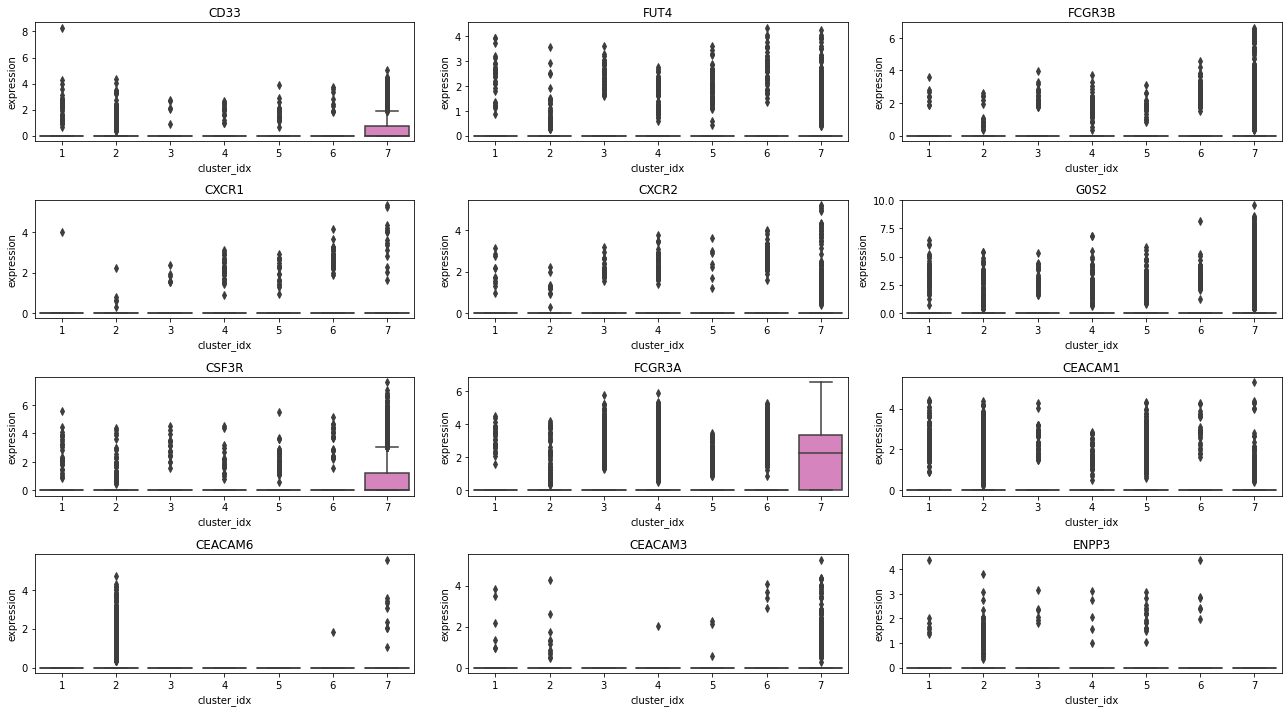

In [168]:
markers_list = list(df['marker'].unique())
# markers_list = list(df['marker'].unique())[int(len(list(df['marker'].unique()))/2):] ## split into 2 when there are many markers (more than 12)
markers_list = list(df['marker'].unique())[12:] ## Takes first 12 markers (more than 12)

plt.figure(figsize=(16,10))
# plt.figure(figsize=(16,56))
fig, axes = plt.subplots(int(np.ceil(len(markers_list)/3)), 3, figsize=(18, 10))
axes = axes.ravel()
axes_indices = [(x,y) for x in range(int(np.ceil(len(markers_list)/3))) for y in range(3)]

for idx, marker_name in enumerate(markers_list):
    
    if len(axes.shape)>1:
        ax = axes[axes_indices[idx][0], axes_indices[idx][1]]
    else:
        ax = axes[idx]
    
    marker_df = df[df['marker']==marker_name]
    g = sns.boxplot(ax=ax, x="cluster_idx", y="expression", data=marker_df);
    ax.set_title(marker_name)
fig.tight_layout()

if len(markers_list)%3>0:
    for i in range(3-len(markers_list)%3, 0, -1):
        axes[-i].remove()

In [169]:
fig.savefig(f'/storage/md_keren/shitay/garbage/myeloid_marker_expression_distributions_p2.jpg')

# Clusters contaminated with fibroblast markers
* Part1: Loads cohort file and kmeans file (should be compatible!!!)
* Part2: shows amount of cells expressing fibroblast markers in cluster
* Part3: builds a DF for use_inferCNV_clustering_to_update_data.py

##### Part1: Loads cohort file and kmeans file (should be compatible!!!)

In [7]:
FILTERED_CELLS_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_10.6.21.pkl'
KMEANS_ROW_CLUSTERS_PATH = r'/storage/md_keren/shitay/outputs/clustering/kmeans/24.5.21/row_kmeans'
KMEANS_FILE_NAME = r'kmeans_immune_cells_4k_genes'  # excluding the suffix: '_k_num.pkl'


In [9]:
K = 15
print(f'Loading cohort file:\n{FILTERED_CELLS_PATH}')
cohort = pickle.load(open(FILTERED_CELLS_PATH, 'rb'))
filtered_cells = cohort.filter_cells_by_property('is_immune', True)

kmeans_file_path = join(KMEANS_ROW_CLUSTERS_PATH, KMEANS_FILE_NAME + f'_k_{K}.pkl')
print(f'Loading kmeans file:\n{kmeans_file_path}')
clusters = pickle.load(open(kmeans_file_path, 'rb'))['clusters']

# markers = find_markers_in_clusters(filtered_cells, clusters)

Loading cohort file:
/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_10.6.21.pkl
Loading kmeans file:
/storage/md_keren/shitay/outputs/clustering/kmeans/24.5.21/row_kmeans/kmeans_immune_cells_4k_genes_k_15.pkl


fib markers start with 'COL1' or 'COL2' or KRT.
Lets find them and their location in the sequencing:

##### Part2: shows amount of cells expressing fibroblast markers in cluster

In [10]:
fib_genes = np.array([[idx, g] for idx, g in enumerate(filtered_cells.gene_names) if g.startswith('COL1') or g.startswith('COL2') or (g.startswith('KRT') and g[3]<='9' and g[3]>='0')])

In [57]:
cls_index = 12
print(f'The number of cells in cluster {cls_index} expressing each number of fibroblast markers')
cluster_cells_indices = clusters[cls_index-1]
cluster_cells = filtered_cells[cluster_cells_indices]

amount_expressing_fib_dic = sort_dic(dict(Counter(np.sum(cluster_cells.counts[:, fib_genes[:,0].astype(int)]>1, axis=1))))
print(f'number of cells expressing exactly:')
print(amount_expressing_fib_dic)

print()
max_markers = np.max(list(amount_expressing_fib_dic.keys()))
more_or_equal_dic = {i:0 for i in range(max_markers+1)}
for n_fib_genes, amount in amount_expressing_fib_dic.items():
    for i in range(n_fib_genes+1):
        more_or_equal_dic[i] += amount
for i in range(max_markers+1):
    print(f'{more_or_equal_dic[i]} ({round(more_or_equal_dic[i]/cluster_cells.number_of_cells*100, 2)}%) cells in cluster express {i} or more fib markers')

The number of cells in cluster 12 expressing each number of fibroblast markers
number of cells expressing exactly:
{0: 401, 1: 901, 2: 822, 3: 736, 4: 419, 5: 296, 6: 345, 7: 143, 8: 53, 9: 31, 10: 9, 11: 3, 14: 1, 15: 1}

4161 (100.0%) cells in cluster express 0 or more fib markers
3760 (90.36%) cells in cluster express 1 or more fib markers
2859 (68.71%) cells in cluster express 2 or more fib markers
2037 (48.95%) cells in cluster express 3 or more fib markers
1301 (31.27%) cells in cluster express 4 or more fib markers
882 (21.2%) cells in cluster express 5 or more fib markers
586 (14.08%) cells in cluster express 6 or more fib markers
241 (5.79%) cells in cluster express 7 or more fib markers
98 (2.36%) cells in cluster express 8 or more fib markers
45 (1.08%) cells in cluster express 9 or more fib markers
14 (0.34%) cells in cluster express 10 or more fib markers
5 (0.12%) cells in cluster express 11 or more fib markers
2 (0.05%) cells in cluster express 12 or more fib markers
2 (

##### Part3: builds a DF for use_inferCNV_clustering_to_update_data.py

In [59]:
df = pd.DataFrame(np.array([cluster_cells.samples, cluster_cells.barcodes]).T, columns=['sample', 'barcode'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4161 entries, 0 to 4160
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   sample   4161 non-null   object
 1   barcode  4161 non-null   object
dtypes: object(2)
memory usage: 65.1+ KB


In [60]:
save_path = f'/storage/md_keren/shitay/Data/tables/kmeans_conclusion_tables/epithelial_contaminated_cells_kmeans24.5.21_k15_cluster12.csv'
df.to_csv(save_path)

# Immune cells fib exploration

The number of immune cells expressing each number of fibroblast markers

In [32]:
print(f'The number of cells expressing each number of fibroblast markers')
sort_dic(dict(Counter(np.sum(filtered_cells.counts[:, fib_genes[:,0].astype(int)]>0, axis=1))))

The number of cells expressing each number of fibroblast markers


{0: 54807,
 1: 23448,
 2: 2525,
 3: 897,
 4: 622,
 5: 432,
 6: 351,
 7: 273,
 8: 176,
 9: 83,
 10: 29,
 11: 4,
 12: 8,
 13: 3,
 14: 2,
 15: 1}

Now lets see if we set a threshold of the minimum number of fib markers, how many cells we would remove from the immune compartment

In [28]:
min_markers = 2
count = 0
dd = sort_dic(dict(Counter(np.sum(filtered_cells.counts[:, fib_genes[:,0].astype(int)]>0, axis=1))))
for k, v in dd.items():
    if k>=min_markers:
        count += v
print(count)

5406


Lets build a table showing for each fib marker how many cells expressing it.

In [29]:
df = pd.DataFrame(columns=['gene', 'number of cells expressing'])
sorted_fib_genes = sorted(fib_genes.tolist(), key=lambda x: x[1])
for marker in sorted_fib_genes:
#     print([marker[1], 0])
    count = sum(filtered_cells.counts[:, int(marker[0])]>0)    
    df = df.append(pd.DataFrame([[marker[1], count]], columns=df.columns))

In [62]:
# df = df.reset_index().drop(columns=['level_0', 'index'])
df.to_csv(r'/storage/md_keren/shitay/garbage/fib_genes_table.csv')

# Debug

In [61]:
sorted_fib_genes
fib_genes

array([['119', 'KRT33A'],
       ['685', 'COL23A1'],
       ['820', 'COL11A1'],
       ['940', 'COL17A1'],
       ['1565', 'COL19A1'],
       ['1633', 'COL16A1'],
       ['2005', 'KRT31'],
       ['2466', 'COL20A1'],
       ['3491', 'KRT23'],
       ['3520', 'KRT37'],
       ['3572', 'KRT32'],
       ['3584', 'COL1A1'],
       ['3834', 'KRT18'],
       ['3948', 'COL12A1'],
       ['5377', 'COL10A1'],
       ['5555', 'COL21A1'],
       ['5789', 'KRT36'],
       ['5995', 'KRT17'],
       ['6460', 'KRT34'],
       ['6461', 'KRT33B'],
       ['7053', 'KRT85'],
       ['7064', 'KRT7'],
       ['7767', 'COL2A1'],
       ['7833', 'KRT71'],
       ['10603', 'KRT84'],
       ['10604', 'KRT82'],
       ['11374', 'COL1A2'],
       ['12136', 'KRT80'],
       ['12137', 'KRT1'],
       ['12175', 'KRT24'],
       ['12535', 'COL22A1'],
       ['12744', 'KRT8'],
       ['12745', 'KRT78'],
       ['12750', 'KRT86'],
       ['12753', 'KRT75'],
       ['12757', 'KRT6C'],
       ['12762', 'KRT4'],
       [

In [6]:
cluster_1_cells.number_of_cells
res = cluster_1_cells.get_subset_by_identifiers(sub_cluster_1_cells.samples, sub_cluster_1_cells.barcodes)

In [24]:
df = pd.DataFrame(np.array([sub_cluster_1_cells.samples, sub_cluster_1_cells.barcodes]).T, columns=['sample', 'barcode'])

path =r'/storage/md_keren/shitay/Data/tables/stroma_contaminated_cells_kmeans_k11_cluster7_expressing_neut.csv'
df.to_csv(path, index=False)

In [12]:
mapping = list(zip(sub_cluster_1_cells.samples, sub_cluster_1_cells.barcodes))

In [16]:
mapping.index(mapping[200])


200

In [22]:
maps = list(zip(cluster_1_cells.samples, cluster_1_cells.barcodes))
dic_map = {vv: [] for vv in set(cluster_1_cells.samples)}
dic_map
for sample_id, barcode in maps:
    dic_map[sample_id].append(barcode)
dic_map

{'M127': ['CTGTTTACACCTGGTG-1', 'TAAACCGTCTCGCTTG-1'],
 'M145': ['AAAGTAGCATATGGTC-1',
  'AAATGCCTCCAGTATG-1',
  'AAATGCCTCCGTCAAA-1',
  'AACCATGGTGCAGACA-1',
  'AACCGCGGTCGATTGT-1',
  'AACTCAGTCTTGTCAT-1',
  'AACTCTTCACGACTCG-1',
  'AACTCTTCAGTACACT-1',
  'AACTCTTGTTACGACT-1',
  'AACTGGTTCTTGCAAG-1',
  'AAGACCTTCATAAAGG-1',
  'AAGGTTCAGTGCTGCC-1',
  'AAGGTTCTCTTCGGTC-1',
  'AAGTCTGGTCCGACGT-1',
  'AATCCAGCAAGGACAC-1',
  'AATCCAGGTCGCGAAA-1',
  'AATCCAGTCTTATCTG-1',
  'AATCGGTTCTAAGCCA-1',
  'AATCGGTTCTGTACGA-1',
  'ACACCAAGTGCAGACA-1',
  'ACACCAAGTTAAAGTG-1',
  'ACACCAATCGCTGATA-1',
  'ACACCCTAGGTGCTTT-1',
  'ACACCGGGTCCTGCTT-1',
  'ACACCGGTCATAAAGG-1',
  'ACACTGAGTGCAGTAG-1',
  'ACACTGATCAACCAAC-1',
  'ACAGCCGAGGCCCGTT-1',
  'ACAGCCGCATAGGATA-1',
  'ACATACGAGGTAAACT-1',
  'ACATACGGTTAAGATG-1',
  'ACATCAGCATTAGGCT-1',
  'ACATCAGTCATGCATG-1',
  'ACATCAGTCGACGGAA-1',
  'ACATCAGTCTTGTACT-1',
  'ACATGGTAGAGGTAGA-1',
  'ACGAGCCAGAAACGCC-1',
  'ACGAGGACACAAGACG-1',
  'ACGAGGAGTCATTAGC-1',
 

In [34]:
barcode_idxs = []
print([(k, len(vv)) for k,vv in dic_map.items()])
for sample_id in sorted(dic_map.keys())[:4]:
    print(sample_id)
    def myfunc(n):
        if sample_id == n[0]:
            return n[1]
        return None
#     barcode_list = [c_barcode for c_sample_id, c_barcode zip(cluster_1_cells.samples, cluster_1_cells.barcodes)]
    barcode_mask_list = list(map(myfunc, zip(cluster_1_cells.samples, cluster_1_cells.barcodes)))
    barcodes_idx = [barcode_mask_list.index(barcode) for barcode in barcode_mask_list]
    barcode_idxs += barcodes_idx
    print(barcode_mask_list)

[('M127', 2), ('M145', 472), ('M109', 10), ('M107', 18), ('M122', 59), ('M123', 1686), ('M129', 12), ('M118', 12), ('M144', 23), ('M140', 2), ('M143', 52), ('M106', 22), ('M97', 17), ('M136', 10), ('M102', 2), ('M108', 1), ('M98', 15), ('M99', 120), ('M124', 11), ('M139', 8), ('M131', 3), ('M135', 19), ('M105', 11), ('M121', 21), ('M133', 1), ('M146', 4), ('M137', 7), ('M111', 42), ('M112', 10), ('M126', 4), ('M100', 1), ('M138', 2), ('M103', 63), ('M110', 222), ('M120', 51), ('M141', 7), ('M134', 16), ('M132', 1), ('M104', 8), ('M101', 275), ('M114', 62), ('M130', 10), ('M128', 17)]
M100
['TCTATTGGTAAGTGTA-1', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

In [27]:
def myfunc(n):
  return len(n)

list(map(myfunc, ('apple', 'banana', 'cherry')) )

[5, 6, 6]